# Dracula Text Analysis 

This notebook focuses on exploring and analysing Bram Stoker's most famous novel: *Dracula*.

The overall purpose is for me to become comfortable with text mining/analysis, but if I happen to come across anything interesting about the text itself, that would be a bonus.

### Import libraries 

In [118]:
import pandas as pd  # Dataframes and data manipulation

from gutenberg.acquire import load_etext  # Import texts from Project Gutenberg
from gutenberg.cleanup import strip_headers # Remove Project Gutenberg headers from the text

import re  # Regex methods

import textstat  # Readability metrics

import matplotlib.pyplot as plt  # Visualisations
import seaborn as sns  # Visualisations

import nltk  # Natural language processing

from nltk.corpus import stopwords, wordnet  # List of common words

from nltk.tokenize import sent_tokenize, word_tokenize  # Split text into significant forms

from nltk.stem import WordNetLemmatizer  # Reduce words to their root form ("lemma")

from nltk import pos_tag  # Tag words with parts of speech

from collections import defaultdict  # Create dictionaries with a default response

from sklearn.feature_extraction.text import CountVectorizer  # Convert text to sparse matrices 

from textblob import TextBlob  # Analyse sentiment

from gensim.models.ldamodel import LdaModel  # Topic extraction

from gensim.models.phrases import Phrases  # ngrams

from gensim import corpora  # Vectorization

import pyLDAvis.gensim  # Visualise topics

In [2]:
# Download nltk data, if required

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

### Set formatting

The following cell contains formatting that applies to the whole notebook.

In [3]:
# Set display column widths for dataframes

pd.set_option("max_colwidth", 450)

# Set the default size for Seaborn plots

sns.set(rc={'figure.figsize':(18, 14)})

# Set a grid background for Seaborn plots

sns.set_style("whitegrid")

# Display Seaborn visualisations with ticks on the axes

sns.set_style("ticks")

### Load the data 

The full text of *Dracula* is available [here](https://www.gutenberg.org/files/345/345-h/345-h.htm) on [Project Gutenberg](https://www.gutenberg.org/); it can be downloaded using the `Gutenberg` Python library.

In [4]:
# Download the full text from Project Gutenberg

raw_text = load_etext(345)

# Remove information about Project Gutenberg, leaving just Dracula behind

raw_text = strip_headers(raw_text)

### Explore the data: initial examination

After downloading *Dracula*, the full text is stored inside the single variable `raw_text`. 

In [5]:
# Check the type of raw_text

type(raw_text)

str

In [6]:
# Get the length of the whole string

len(raw_text)

847580

In [7]:
# Examine the first 1000 characters of raw_text

raw_text[:1000]

"\n\n\n\n\n\n\n                                DRACULA\n\n\n\n\n\n                                DRACULA\n\n                                  _by_\n\n                              Bram Stoker\n\n                        [Illustration: colophon]\n\n                                NEW YORK\n\n                            GROSSET & DUNLAP\n\n                              _Publishers_\n\n      Copyright, 1897, in the United States of America, according\n                   to Act of Congress, by Bram Stoker\n\n                        [_All rights reserved._]\n\n                      PRINTED IN THE UNITED STATES\n                                   AT\n               THE COUNTRY LIFE PRESS, GARDEN CITY, N.Y.\n\n\n\n\n                                   TO\n\n                             MY DEAR FRIEND\n\n                               HOMMY-BEG\n\n\n\n\nCONTENTS\n\n\nCHAPTER I\n                                                                    Page\n\nJonathan Harker's Journal                 

### Clean the data: remove irrelevant text

`raw_text` clearly contains a lot of special characters that we don't need to preserve; they provide information about formatting, but will complicate our analysis. The first stage of cleaning will be to remove them all.

Characters to be removed:

* `\n` and `\r` - special characters that format the text
* `[` and `]` - used to display metadata; anything between them will also be removed

In [8]:
# Replace the special characters with a space

raw_text = re.sub("\\n|\\r|\[.+?\]", " ", raw_text)

# Replace any set of two or more spaces with just a single space

raw_text = re.sub(" {2,}", " ", raw_text)

An additional problem is that `raw_text` contains the introductory and final pages as part of the string - these contain information about the book, author, and publisher, but are not useful to our analysis. 

In [9]:
# Find the location of "DRACULA CHAPTER I"

start = re.search("DRACULA CHAPTER I", raw_text)

# Find the location of "THE END"

end = re.search("THE END", raw_text)

# Remove everything before "DRACULA CHAPTER I" and after "THE END"

raw_text = raw_text[start.start():end.end()]

In [10]:
# Re-examine the first 1000 characters

raw_text[:1000]

"DRACULA CHAPTER I JONATHAN HARKER'S JOURNAL (_Kept in shorthand._) _3 May. Bistritz._--Left Munich at 8:35 P. M., on 1st May, arriving at Vienna early next morning; should have arrived at 6:46, but train was an hour late. Buda-Pesth seems a wonderful place, from the glimpse which I got of it from the train and the little I could walk through the streets. I feared to go very far from the station, as we had arrived late and would start as near the correct time as possible. The impression I had was that we were leaving the West and entering the East; the most western of splendid bridges over the Danube, which is here of noble width and depth, took us among the traditions of Turkish rule. We left in pretty good time, and came after nightfall to Klausenburgh. Here I stopped for the night at the Hotel Royale. I had for dinner, or rather supper, a chicken done up some way with red pepper, which was very good but thirsty. (_Mem._, get recipe for Mina.) I asked the waiter, and he said it was c

We now have a complete and somewhat clean copy of *Dracula* - just the text of the novel itself, without special characters or strange spacing.

### Analyse the data: readability

We can run some basic readability stats on *Dracula* using `textstat`.

In [11]:
print("~~~ Dracula ~~~")
print("~~~~~~~~~~~~~~~")
print(f"Number of characters: {textstat.char_count(raw_text)}")
print(f"Number of syllables: {textstat.syllable_count(raw_text, lang='en_UK')}")
print(f"Number of words: {textstat.lexicon_count(raw_text)}")
print(f"Number of sentences: {textstat.sentence_count(raw_text)}")
print("~~~~~~~~~~~~~~~")
print(f"Average word length: {textstat.avg_letter_per_word(raw_text)}")      
print(f"Average sentence length: {textstat.avg_sentence_length(raw_text)}")
print("~~~~~~~~~~~~~~~")
print(f"Flesch reading ease: {textstat.flesch_reading_ease(raw_text)}")
print(f"SMOG index: {textstat.smog_index(raw_text)}")
print(f"Flesch-Kincaid grade: {textstat.flesch_kincaid_grade(raw_text)}")
print(f"Coleman-Liau index: {textstat.coleman_liau_index(raw_text)}")
print(f"ARI: {textstat.automated_readability_index(raw_text)}")
print(f"Dale-Chall readability: {textstat.dale_chall_readability_score(raw_text)}")
print(f"Difficult words: {textstat.difficult_words(raw_text)}")
print(f"Linsear write formula: {textstat.linsear_write_formula(raw_text)}")
print(f"Gunning fog index: {textstat.gunning_fog(raw_text)}")
print(f"Text standard: {textstat.text_standard(raw_text)}")
print("~~~~~~~~~~~~~~~")

~~~ Dracula ~~~
~~~~~~~~~~~~~~~
Number of characters: 674443
Number of syllables: 198341
Number of words: 160148
Number of sentences: 7505
~~~~~~~~~~~~~~~
Average word length: 4.0
Average sentence length: 21.3
~~~~~~~~~~~~~~~
Flesch reading ease: 83.7
SMOG index: 8.6
Flesch-Kincaid grade: 6.9
Coleman-Liau index: 5.92
ARI: 9.1
Dale-Chall readability: 1.57
Difficult words: 5217
Linsear write formula: 8.5
Gunning fog index: 9.04
Text standard: 8th and 9th grade
~~~~~~~~~~~~~~~


### Explore the data: characters and symbols 

At present, the data is still in one vast string, which will require an awful lot of cleaning to make sense of. Still, some basic information can be extracted.

In [12]:
# How many characters in total?

print(f"The full text of 'Dracula' contains {len(raw_text)} characters in total.")

The full text of 'Dracula' contains 835257 characters in total.


In [13]:
# How many occurrences of each separate letter?

# Get a lowercase version of the string

lower_dracula = raw_text.lower()

# Count the occurrences of each letter in the string

letter_counts = [(letter, lower_dracula.count(letter)) for letter in "abcdefghijklmnopqrstuvwxyz"]

# Create a dataframe from the counts

letter_df = pd.DataFrame(columns=["letter", "frequency"], data=letter_counts)

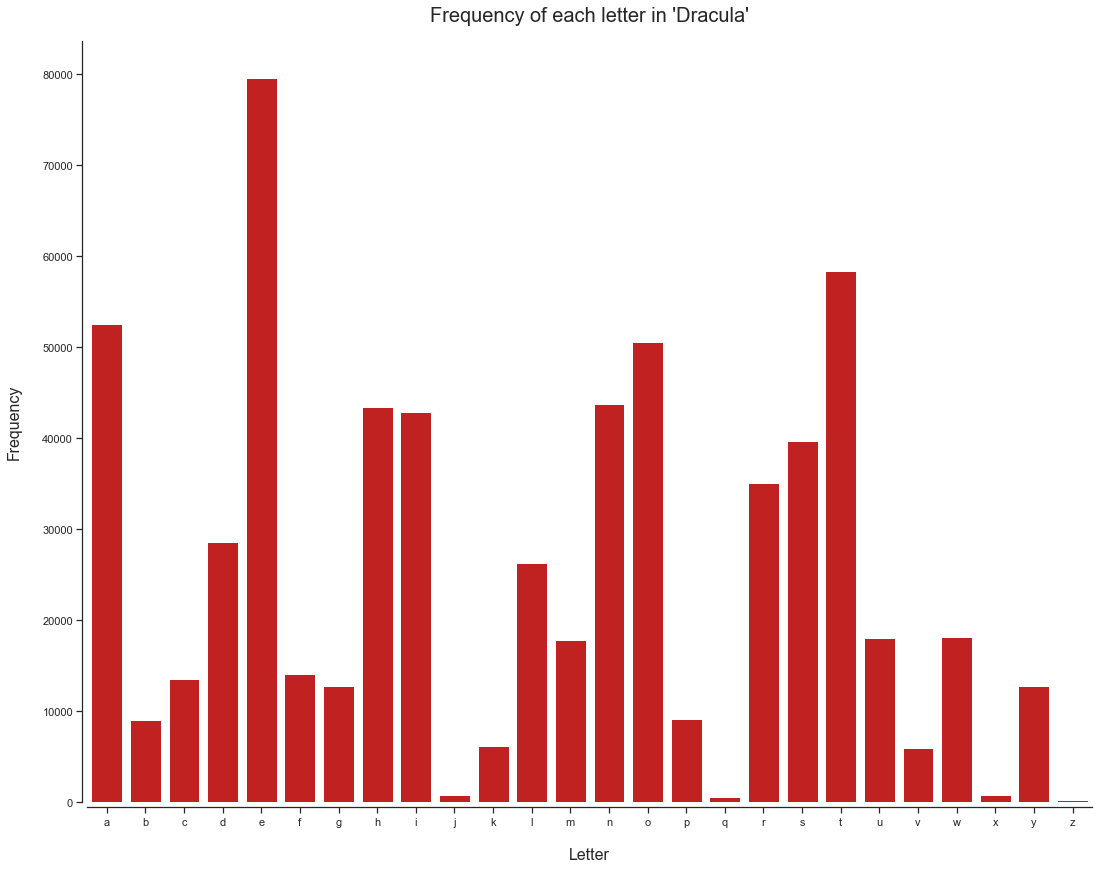

In [14]:
# Plot the frequencies

# Colour the bars blood-red for thematic reasons

plot = sns.barplot(x="letter", y="frequency", color="#DA0707", data=letter_df)

# Style the plot

plot.set_title("Frequency of each letter in 'Dracula'", fontsize=20, pad=20)
plot.set_xlabel("Letter", fontsize=16, labelpad=20)
plot.set_ylabel("Frequency", fontsize=16, labelpad=20)

sns.despine(ax=plot, offset=5)

Everything is as expected - "e", the most common letter in the English language, is the most prevalent here, while less common letters such as "j" and "x" barely appear at all. 

In [15]:
# Find all the punctuation in the text

punctuation = re.findall("[^\w\s]", raw_text)

# Output the total number of symbols

print(f"'Dracula' contains {len(punctuation)} punctuation marks.")

'Dracula' contains 32146 punctuation marks.


In [16]:
# Create a unique set of the punctuation marks

punctuation_set = set(punctuation)

# Use the set to generate the frequencies of each piece of punctuation

punctuation_counts = [(mark, punctuation.count(mark)) for mark in punctuation_set]

# Convert the marks and frequencies into a dataframe

punctuation_df = pd.DataFrame(columns=["mark", "frequency"], data=punctuation_counts)

# Sort the dataframe

punctuation_df.sort_values(by="frequency", ascending=False, inplace=True)

In [17]:
# Inspect the punctuation data

punctuation_df

,mark,frequency
12,",",11232
7,.,8256
0,-,3837
10,"""",2927
9,;,1681
4,',1610
6,!,749
1,*,640
15,:,635
5,?,492


It might seem as though this analysis is trivial, and that there's nothing particularly interesting here, but I disagree. Some insights about Stoker's style can be extracted from this.

From the above dataframe, for example, it's easy to count the number of times terminating punctuation (punctuation that ends a sentence, rather than continues it) appears.

In [18]:
# Count the number of times terminating punctuation appears

terminator_count = punctuation_df[punctuation_df['mark'].isin([".", "!", "?"])]['frequency'].sum()

print(f"'Dracula' contains {terminator_count} separate pieces of terminating punctuation.")

'Dracula' contains 9497 separate pieces of terminating punctuation.


The fact that all the terminating punctuation, added together, is still smaller than the number of commas (not even including other continuing punctuation), shows that Bram Stoker had a preference for long, complex sentences. This is obvious if you read *Dracula*, but it is good to have mathematical confirmation.

In fact, the use of commas over terminators is even more marked than this - the dataframe does not count ellipsis at all, so the number of full stops is inflated. 

By discounting ellipsis from the terminating count, we can calculate a rough count of sentences in the whole text - one for each terminating mark. Ellipsis can be discounted here because it is always (in this specific text), accompanied by another mark when it ends a sentence.

In [19]:
# Find all the ellipses in the text

ellipsis_match = re.findall("\.{3}", raw_text)

# Store the number of full stops

stop_count = int(punctuation_df[punctuation_df['mark'] == "."]['frequency'])

# Calculate and output how many full stops are actually sentence terminators

print(("'Dracula' contains {len(match)} examples of ellipsis, so the actual "
       f"count of full stops is only {stop_count - len(ellipsis_match) * 3}, not {stop_count}."))

'Dracula' contains {len(match)} examples of ellipsis, so the actual count of full stops is only 8022, not 8256.


In [20]:
# Calculate a tentative count of sentences

sentence_count = punctuation_df[punctuation_df['mark'].isin([".",
                                                             "!",
                                                             "?"])]['frequency'].sum() - (len(ellipsis_match) * 3)

print(("Just by looking at the punctuation, we can (tentatively) "
      f"determine that 'Dracula' contains {sentence_count} separate sentences."))

Just by looking at the punctuation, we can (tentatively) determine that 'Dracula' contains 9263 separate sentences.


That sentence count is not the same as the one generated by `textstat`, but this is to be expected - they are both rough estimates.

It's also worth looking at the curly brackets - three pairs appear in the full text, and that's quite surprising, as that specific punctuation is not used in normal prose.

In [21]:
# Greedily-grab all the information between the first opening and last closing curly bracket

curl_match = re.search("{.+}", raw_text)

# Hard-code indices to show the full sentence

raw_text[curl_match.start() - 58: curl_match.end()+2]

"If I don't sleep at once, chloral, the modern Morpheus--C_{2}HCl_{3}O. H_{2}O!"

All three pairs of brackets appear in a single sentence (shown above). The brackets are used - on Project Gutenberg itself - to format the line using subscript, displaying a chemical formula.

\begin{equation*}
C_{2}HCl_{3}O. H_{2}O
\end{equation*}

This is the formula for [chloral hydrate](https://en.wikipedia.org/wiki/Chloral_hydrate), a sedative that dates back to 1832. Seward takes it sometimes, to help him sleep. 

Eventually, we will remove the formula, as it is not required for later analysis, but looking into why the brackets are in the text has already sent me down an interesting rabbit-hole of researching the history of sedatives.

### Transform the data: sentences and chapters

While exploring the text at character-level was surprisingly engrossing, more complex analysis has to take place at the word-, sentence-, and chapter-level. 

To this end, the next step is to break the text from one long string into sentences. These can then be grouped by chapter, or broken down by word.

Even before the string can be broken into sentences, we need to remove punctuation that could complicate things.

In [22]:
# Remove ellipsis (but not single full stops, or full stops immediately following ellipsis)

raw_text = re.sub("\.{3}", "", raw_text)

# Remove the chemical formula

raw_text = re.sub("{.+}", "", raw_text)

Another problem is that the chapter headings don't end in full stops, and neither do all of the notes explaining where a particular piece of text has come from - Seward's phonograph, or Mina's letters, or various snippets of letters to and from various minor characters.

Ideally, the chapter headings and notes would be treated as separate sentences, and so the raw text will have to be manipulated until that is the case.

In [23]:
# Add a full stop to the end of every chapter heading, so it is treated as a sentence.

raw_text = re.sub("(CHAPTER [IVX]+|NOTE)", r"\1.", raw_text)

# The notes are not always consistently formatted - some of them end in a full stop (which is fine), others don't.
# Some are italicised, others are capitalised. Others are in brackets for no discernable reason.

# Remove all italics

raw_text = re.sub("_", "", raw_text)

# Find all the notes ending in ""--continued" but not followed by a full stop, and add the stop in

raw_text = re.sub("(--continued)", r"\1.", raw_text)

# Remove punctuation that might be confusing to the tokenizer

raw_text = re.sub("-|\*+", " ", raw_text)

# Replace semicolons with full stops - increases the number of separate sentences a lot

raw_text = re.sub(";", ".", raw_text)

# Replace colons and brackets with nothing

raw_text = re.sub("[:\(\)]", "", raw_text)

# Remove speech marks, losing information but simplifying the text

raw_text = re.sub('"', " ", raw_text)

# Remove any stray spaces that might have snuck in during previous cleaning

raw_text = re.sub(" {2,}", " ", raw_text)

The above cleaning should allow the tokenizer to split the text into separate sentences without two many errors or issues.

In [24]:
# Split the text into sentences

sentences = sent_tokenize(raw_text)

# Output the number of sentences created

print(f"Divided the text into {len(sentences)} sentences.")

Divided the text into 10473 sentences.


With the text divided into sentences, we can now create a dataframe that allows easy manipulation of the text.

The next cell loops through the list of sentences, keeping track of the last chapter heading seen, so that the chapter for a particular sentence can be attached to the sentence in the dataframe.

Similarly, the date can be discerned and attached to the sentence. As Stoker used a (mostly) consistent style for dates throughout the novel, it is possible to attach the most recently mentioned date to each sentence, and thus keep a track of roughly when each sentence appears in the novel's chronology. This is not an exact figure, as characters do refer to other dates during their narration, and, in places, time may advance without the date being explicitly named. 

In [25]:
# Loop through the sentences, creating a tuple for each one
# Each tuple should contain the text, the chapter number, and the date
# There will definitely be issues with the date being inaccurate

# Holder for completed tuples

sentence_tuples = []

# Counter for the current chapter

chapter_number = 0

# Holder for the rough date

date = ""

for sentence in sentences:
    
    if "CHAPTER" in sentence:
        chapter_number += 1
    
    date_match = re.search("\d+? [JFMASOND][a-zA-Z]{2,8}", sentence)
    
    if date_match:
        date = date_match.group()
        
    if "NOTE" in sentence:
        chapter_number += 1
        date = ""
    
    sentence_tuple = (sentence, chapter_number, date)
    
    sentence_tuples.append(sentence_tuple)
    
dracula_df = pd.DataFrame(columns=["raw_sentence", "chapter", "date"], data=sentence_tuples)

In [26]:
# Inspect a random sample of the dataframe

dracula_df.sample(10)

,raw_sentence,chapter,date
242,The driver saw it at the same moment.,1,5 May
1680,"He has evidently some deep problem in his mind, for he keeps a little note book in which he is always jotting down something.",6,1 July
5803,"God bless you that you have given my dear one her soul again, and me peace.",16,29 September
2732,"He suddenly redoubled his efforts, and then as suddenly grew calm.",9,23 August
10080,When I wake I try to hypnotise her.,27,4 November
1095,"Then I went over every inch of the ground, so as not to lose a chance.",4,25 June
1197,"the cheeks were fuller, and the white skin seemed ruby red underneath.",4,30 June
5470,Arthur stood up.,15,29 September
78,"When I asked him if he knew Count Dracula, and could tell me anything of his castle, both he and his wife crossed themselves, and, saying that they knew nothing at all, simply refused to speak further.",1,4 May
3452,"How blessed are some people, whose lives have no fears, no dreads.",11,12 September


### Clean the data: letters and punctuation

Now the data is divided into sentences, we can clean it more effectively for analysis - removing punctuation, getting rid of uppercase letters, etc. 

In [27]:
# Create a clean_text column to transform the data, preserving the original

# Remove all digits & A.M./P.M

dracula_df["clean_sentence"] = dracula_df["raw_sentence"].str.replace("\d|[AP]\. M\.", "", regex=True)

# Convert all the sentences to lowercase

dracula_df["clean_sentence"] = dracula_df["clean_sentence"].str.lower()

# Replace n't with not and 's with nothing - loses information but avoids later errors

dracula_df["clean_sentence"] = dracula_df["clean_sentence"].str.replace("n't", " not")

dracula_df["clean_sentence"] = dracula_df["clean_sentence"].str.replace("'s", "")

# Remove all remaining punctuation

dracula_df["clean_sentence"] = dracula_df["clean_sentence"].str.replace("[^\w\s]", "", regex=True)

# Remove st/rd/th - legacy of removed numbers

dracula_df["clean_sentence"] = dracula_df["clean_sentence"].str.replace(" (st|rd|th) ", " ", regex=True)

# Remove chapter headings

dracula_df["clean_sentence"] = dracula_df["clean_sentence"].str.replace("chapter [ixv]+|^note$", "", regex=True)

In [28]:
# Inspect the cleaned data

dracula_df[["clean_sentence"]].sample(10)

,clean_sentence
2116,to die like a sailor in blue water no man can object
5397,therefore i shall fix some things she like not garlic and a crucifix and so seal up the door of the tomb
7208,i know that i shall never lack the means of life
345,i must regret that an attack of gout from which malady i am a constant sufferer forbids absolutely any travelling on my part for some time to come
2252,i did not wait to catch another glance but flew down the steep steps to the pier and along by the fish market to the bridge which was the only way to reach the east cliff
4115,he begins to doubt himself
778,one or two small rooms near the hall were open but there was nothing to see in them except old furniture dusty with age and moth eaten
9122,she answers to the first nothing
10159,then they began to materialise till if god have not take away my reason for i saw it through my eyes there were before me in actual flesh the same three women that jonathan saw in the room when they would have kissed his throat
3388,for me


### Explore the data: sentence lengths 

We've already identified that Bram Stoker used long sentences, but it's interesting to look at exactly how long the sentences tended to be. 

In [29]:
# Calculate the length of every sentence

lengths = list(dracula_df["raw_sentence"].apply(lambda x: len(x.split(" "))))

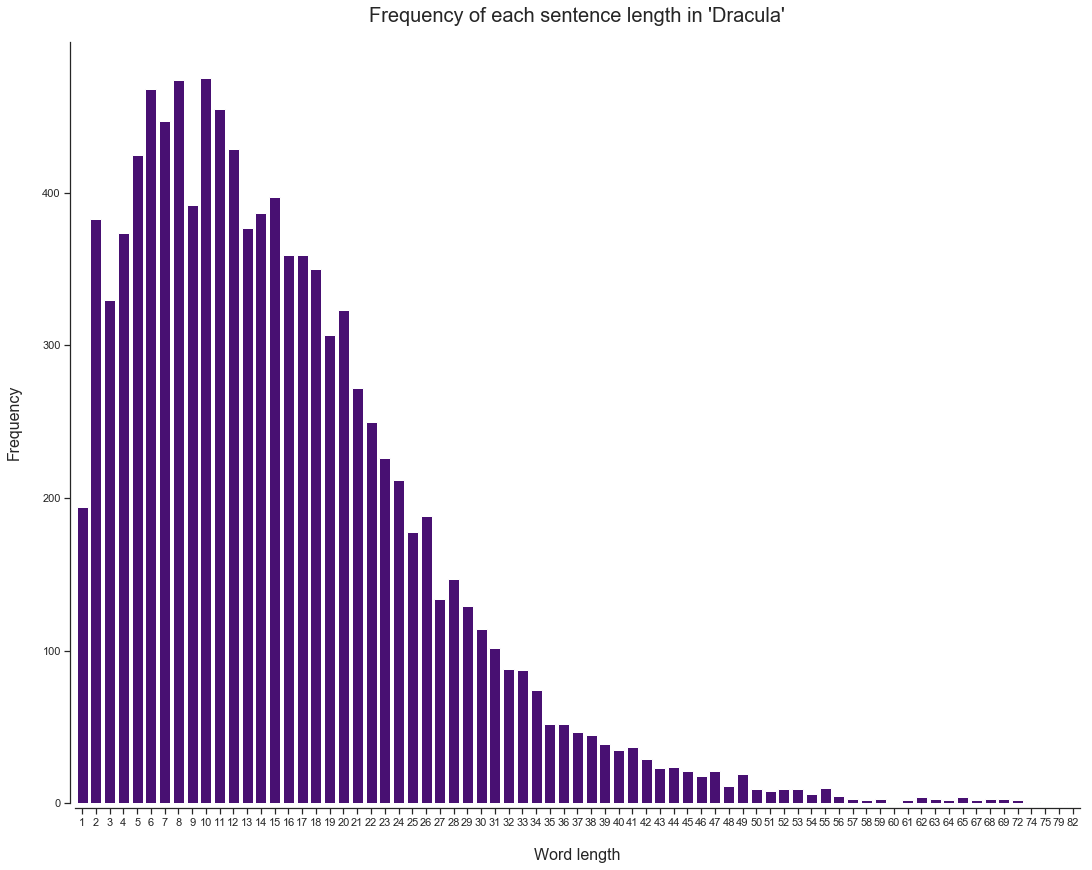

In [30]:
# Plot the count for each distinct sentence length

plot = sns.countplot(x=lengths, color="#4B0082")

# Style the plot
plot.set_title("Frequency of each sentence length in 'Dracula'", fontsize=20, pad=20)
plot.set_xlabel("Word length", fontsize=16, labelpad=20)
plot.set_ylabel("Frequency", fontsize=16, labelpad=20)

sns.despine(ax=plot, offset=5)

In [31]:
# Get the average sentence length

print(f"Mean sentence length: {sum(lengths) / len(lengths)}")

Mean sentence length: 15.471116203571087


### Clean the data: extract keywords

In [32]:
# Create a keywords column that only contains significant words

# Split the text into words

dracula_df["keywords"] = dracula_df["clean_sentence"].apply(word_tokenize)

# Remove insignificant words ("stopwords") and one-letter words

stop = stopwords.words("english")  # nltk stopwors list
stop.extend("mem")  # Add specific words

dracula_df["keywords"] = dracula_df["keywords"].apply(lambda x: [w for w in x if w not in stop and len(w) > 2])

In [33]:
# Lemmatize the words, reducing them back to their stems

# Object to lemmatize words 

lemma = WordNetLemmatizer()

# Dictionary to convert between part-of-speech tags and the ones the lemmatizer understands

tag_dict = defaultdict(lambda : wordnet.NOUN)
tag_dict['J'] = wordnet.ADJ
tag_dict['V'] = wordnet.VERB
tag_dict['R'] = wordnet.ADV

# function to lemmatize a sentence

def get_lemma(word):
    """Gets the POS tag for a word, and then returns the lemmatized form of the word"""
    tag = pos_tag([word])[0][1][0]
    tag = tag_dict[tag]
    
    return lemma.lemmatize(word, tag)

# Actually perform the lemmatization

dracula_df["keywords"] = dracula_df["keywords"].apply(lambda x: [get_lemma(word) for word in x])

In [34]:
# Inspect the keywords column

dracula_df.sample(10)

,raw_sentence,chapter,date,clean_sentence,keywords
6212,"When we had finished, Mrs. Harker said Dr. Seward, may I ask a favour?",18,30 September,when we had finished mrs harker said dr seward may i ask a favour,"[finish, mr, harker, say, seward, may, ask, favour]"
5562,"Arthur looked on, very pale but silent.",16,29 September,arthur looked on very pale but silent,"[arthur, look, pale, silent]"
5447,"It is, I know, much to ask.",15,29 September,it is i know much to ask,"[know, much, ask]"
5943,"Take the cylinders and hear them the first half dozen of them are personal to me, and they will not horrify you.",17,29 September,take the cylinders and hear them the first half dozen of them are personal to me and they will not horrify you,"[take, cylinder, hear, first, half, dozen, personal, horrify]"
7020,"However, when I had found the court, I had no difficulty in discovering Corcoran's lodging house.",20,2 October,however when i had found the court i had no difficulty in discovering corcoran lodging house,"[however, found, court, difficulty, discover, corcoran, lodge, house]"
8414,"We are all drifting reefwards now, and faith is our only anchor.",23,4 October,we are all drifting reefwards now and faith is our only anchor,"[drift, reefwards, faith, anchor]"
2221,"The room was dark, so I could not see Lucy's bed.",8,11 August,the room was dark so i could not see lucy bed,"[room, dark, could, see, lucy, bed]"
3734,"As she lay there in my arms, and I in hers, the flapping and buffeting came to the window again.",11,17 September,as she lay there in my arms and i in hers the flapping and buffeting came to the window again,"[lay, arm, flap, buffeting, come, window]"
3693,to night I could not well do without it.,11,17 September,to night i could not well do without it,"[night, could, well, without]"
7709,"but, as I took it that it was with a purpose, I said nothing.",21,3 October,but as i took it that it was with a purpose i said nothing,"[take, purpose, say, nothing]"


In [35]:
# Create a new column containing the number of keywords per sentence

dracula_df["keyword_count"] = dracula_df["keywords"].apply(lambda x: len(x))

In [36]:
# Drop rows with zero keywords

dracula_df = dracula_df[dracula_df["keyword_count"] > 0]

# Drop rows that simply contain the name of a month

# Set holding months

months = {"january", "february", "march", "april", "may", "june",
          "july", "august", "september", "november", "december"}

# Filter the dataset, keeping only the columns where the keywords column
# is not a subset of months

dracula_df = dracula_df[~dracula_df["keywords"].map(lambda x: set(x).issubset(months))]

### Explore the data: word frequencies (whole novel) 

In [57]:
# Convert the keywords column into a document-term matrix

keywords_series = dracula_df["keywords"].apply(lambda x: " ".join(x))

# Create an object that converts strings into a sparse matrix

vectorizer = CountVectorizer(max_features= 10000 , min_df=0.005, ngram_range= (1,1))

# Convert the keywords series to a sparse matrix

dracula_dtm = vectorizer.fit_transform(keywords_series)

In [58]:
# Inspect the sparse matrix

dracula_dtm

<10194x271 sparse matrix of type '<class 'numpy.int64'>'
	with 35832 stored elements in Compressed Sparse Row format>

In [59]:
# Create a dataframe of terms and frequencies

# Get the frequency of each term

keyword_frequencies = dracula_dtm.sum(axis=0)

# Match frequencies to terms

frequent_terms = [(word, keyword_frequencies[0, id]) for word, id in vectorizer.vocabulary_.items()]

# Convert the word-frequency pairings to a dataframe

keyword_df = pd.DataFrame(columns=["term",
                                   "frequency"], data=frequent_terms)

# Sort the dataframe

keyword_df.sort_values(by="frequency", ascending=False, inplace=True)

In [60]:
# Inspect the most frequent terms

keyword_df.head(10)

,term,frequency
33,say,812
25,come,804
77,see,529
43,one,515
13,could,508
89,look,469
37,know,467
23,take,463
53,go,452
20,time,447


It's a disappointing result, but one that makes sense. The first novel-specific word is "helsing", over twenty places down in the list (matching 'van' perfectly, however). However, with such a long text, functional words such as "say" are going to be more frequent than any name.

Searching directly for names will hopefully be more successful.

In [61]:
# Create a list of plot-specific keywords

plot_keywords = ["jonathan", "harker", "mina", "murray", "lucy", "westenra", "seward", "renfield", "arthur", "holmwood",
              "quincy", "morris", "helsing", "dracula", "vampire", "blood", "undead", "love"]


# Return frequencies for selected terms

keyword_df[keyword_df["term"].isin(plot_keywords)]

,term,frequency
270,helsing,322
257,lucy,299
31,mina,237
0,jonathan,201
1,harker,166
258,arthur,147
235,love,133
262,seward,128
241,blood,113
263,morris,78


Those results are a little more interesting, but still it's clear that character names & plot-related words are actually rather infrequent in the novel. "Dracula" isn't in the list of most frequent terms at all.

In [62]:
# How many times does "Dracula" appear in the novel?

dracula_count = raw_text.lower().count("dracula")

print(f"The word 'Dracula' appears in the novel only {dracula_count} times.")

The word 'Dracula' appears in the novel only 36 times.


Because of the prevalence of functional words rather than plot-specific ones in the most frequent terms, it doesn't really make sense to create wordclouds or plot character mentions over time. Instead, we'll move onto sentiment analysis.

### Explore the data: sentiment analysis

We can analyse the sentiment/emotional content of each sentence.

In [43]:
# Function to get the sentiment score for a particular sentence

def get_sentiment(sentence):
    """Return a sentiment score between -1 and 1"""
    blob = TextBlob(sentence)
    return blob.sentiment.polarity

# 1 is fully positive, -1 is fully negative

# Create a new column, sentiment_score. Generate it from raw_sentence, to preserve all relevant vocabulary

dracula_df["sentiment_score"] = dracula_df["raw_sentence"].apply(lambda x: get_sentiment(x))

In [44]:
# Display the most negative sentiments

dracula_df.sort_values(by="sentiment_score").head()

,raw_sentence,chapter,date,clean_sentence,keywords,keyword_count,sentiment_score
1798,This suspense is getting dreadful.,6,6 August,this suspense is getting dreadful,"[suspense, get, dreadful]",3,-1.0
8020,"When it was over, Van Helsing stood up and said Now, my dear friends, we go forth to our terrible enterprise.",22,3 October,when it was over van helsing stood up and said now my dear friends we go forth to our terrible enterprise,"[van, helsing, stood, say, dear, friend, forth, terrible, enterprise]",9,-1.0
8033,and the two so overwhelmed her that her overwrought nature had its voice in that dreadful scream.,22,3 October,and the two so overwhelmed her that her overwrought nature had its voice in that dreadful scream,"[two, overwhelmed, overwrought, nature, voice, dreadful, scream]",7,-1.0
8056,and we prayed for help and guidance in the terrible task which lay before us.,22,3 October,and we prayed for help and guidance in the terrible task which lay before us,"[prayed, help, guidance, terrible, task, lay]",6,-1.0
10197,The accident to the launch has been a terrible thing for us.,27,4 November,the accident to the launch has been a terrible thing for us,"[accident, launch, terrible, thing]",4,-1.0


In [45]:
# And the most positive ones

dracula_df.sort_values(by="sentiment_score").tail()

,raw_sentence,chapter,date,clean_sentence,keywords,keyword_count,sentiment_score
7807,for Dr. Van Helsing and Dr. Seward are agreed that if we do not eat we cannot work our best.,22,3 October,for dr van helsing and dr seward are agreed that if we do not eat we cannot work our best,"[van, helsing, seward, agree, eat, work, best]",7,1.0
7808,"Our best will be, God knows, required to day.",22,3 October,our best will be god knows required to day,"[best, god, know, require, day]",5,1.0
7927,"I have thought and thought, and it seems to me that the simplest way is the best of all.",22,3 October,i have thought and thought and it seems to me that the simplest way is the best of all,"[thought, thought, seem, simplest, way, best]",6,1.0
584,"The view was magnificent, and from where I stood there was every opportunity of seeing it.",2,8 May,the view was magnificent and from where i stood there was every opportunity of seeing it,"[view, magnificent, stood, every, opportunity, see]",6,1.0
7003,But it is best as it is.,20,1 October,but it is best as it is,[best],1,1.0


The sentiment scores are crude but seem to be generally in the right line - "God knows that there is ground for my terrible fear in this accursed place!" is much more negative than "Ah, that wonderful Madam Mina, he said, pearl among women!".

In [46]:
# Get the mean sentiment across the whole text

mean_sentiment = dracula_df["sentiment_score"].sum() / dracula_df.shape[0]

print(f"The overall sentiment for the entire novel is {mean_sentiment}.")

The overall sentiment for the entire novel is 0.046964725842465256.


In [47]:
# Create a dataframe of mean sentiment for each chapter

dracula_chapter_df = dracula_df.groupby(by="chapter").mean().reset_index()[["chapter", "sentiment_score"]]

In [48]:
# Inspect the chapter scores

dracula_chapter_df

,chapter,sentiment_score
0,1,0.058790
1,2,0.091763
2,3,0.068893
3,4,0.031885
4,5,0.110582
5,6,0.073940
6,7,0.024034
7,8,0.056293
8,9,0.052772
9,10,0.064162


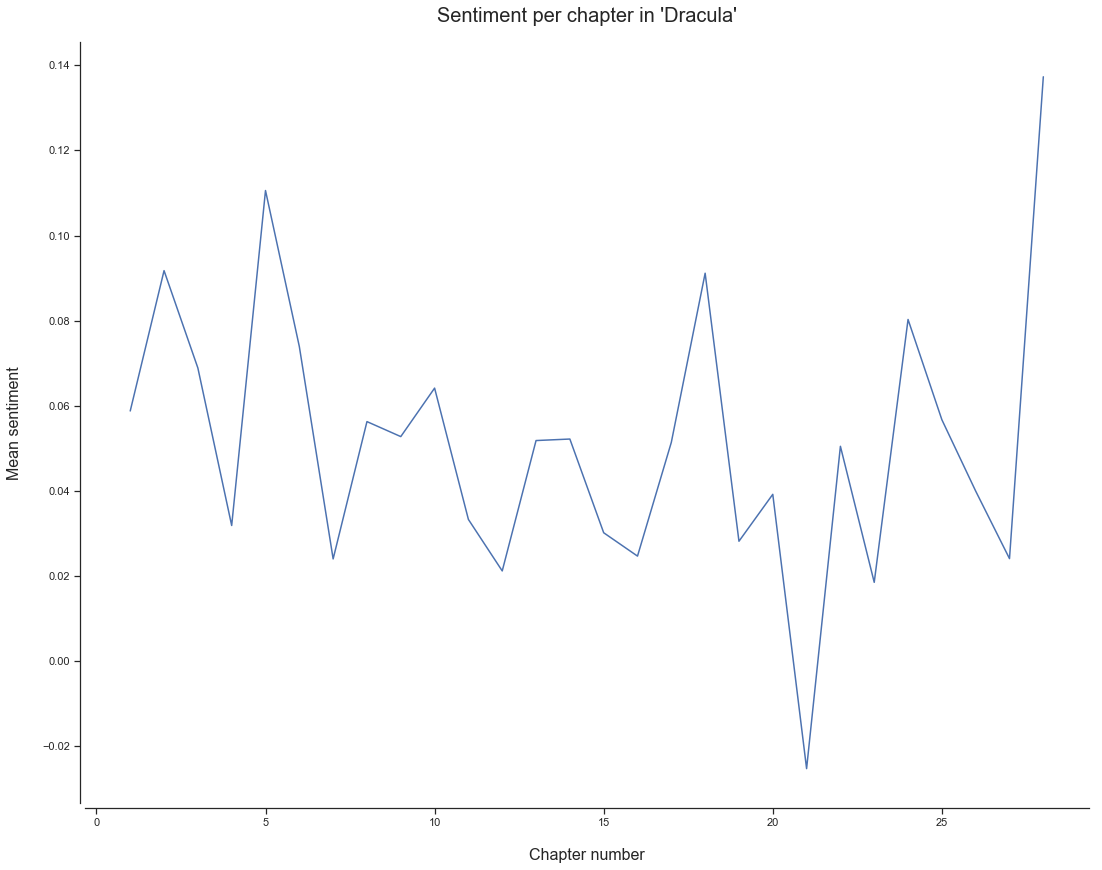

In [49]:
# Plot the mean sentiment by chapter

plot = sns.lineplot(x="chapter", y="sentiment_score", data=dracula_chapter_df)

# Style the plot

plot.set_title("Sentiment per chapter in 'Dracula'", fontsize=20, pad=20)
plot.set_xlabel("Chapter number", fontsize=16, labelpad=20)
plot.set_ylabel("Mean sentiment", fontsize=16, labelpad=20)

sns.despine(ax=plot, offset=5)

This is not quite what I expected, but it does make some sort of sense - the huge uptick towards the end, for example, is the final chapter after Dracula's death and Mina's salvation. 

Chapter 21 - the deepest trough - is the chapter that deals with Dracula's assault on Mina. However chapter 4 - the second highest peak - is the chapter where Harker is trapped in his room, torn between suicide and attempting to kill Dracula. The sentiment classifier has struggled with some sentences, and declared that "I saw in his eyes something of that gathering wrath which was manifest when he hurled that fair woman from him" is highly positive (0.7).

Chapters might be too wide a net to capture shifts in sentiment. We'll try again with smaller sections, in the hope that this will even the line out and limit the effect of mis-classified sentiments. 

In [50]:
# Reset the index and drop the old one, to account for removed rows

dracula_df = dracula_df.reset_index().drop(columns=["index"], axis=1)

# Group the dataset by every hundred rows

sentence_df = dracula_df.groupby(by=lambda x: x//100, axis=0).mean().reset_index()[["sentiment_score"]]

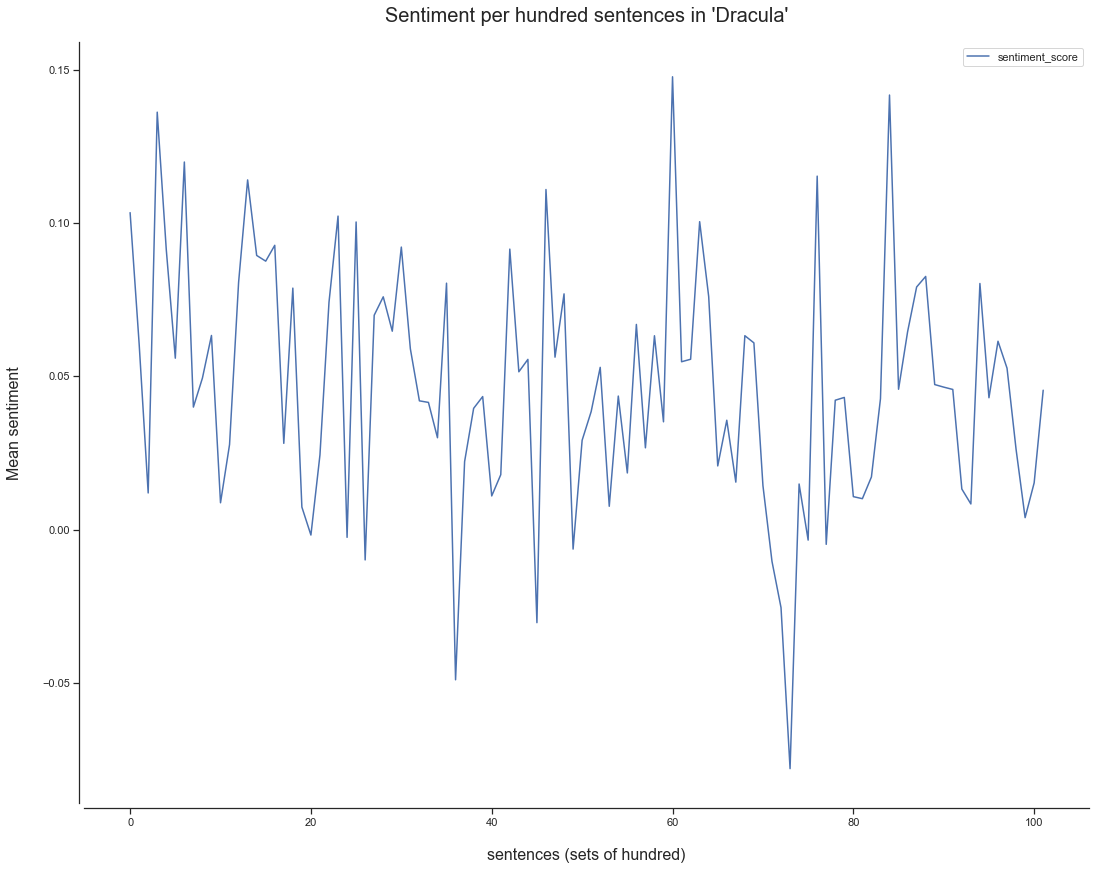

In [51]:
# Plot the mean sentiment every hundred sentences

plot = sns.lineplot(data=sentence_df)

# Style the plot

plot.set_title("Sentiment per hundred sentences in 'Dracula'", fontsize=20, pad=20)
plot.set_xlabel("sentences (sets of hundred)", fontsize=16, labelpad=20)
plot.set_ylabel("Mean sentiment", fontsize=16, labelpad=20)

sns.despine(ax=plot, offset=5)

In [52]:
# Examine the lowest mean sentiments

sentence_df.sort_values(by="sentiment_score").head()

,sentiment_score
73,-0.077855
36,-0.048889
45,-0.030266
72,-0.025363
71,-0.010272


In [53]:
# And the highest

sentence_df.sort_values(by="sentiment_score").tail()

,sentiment_score
76,0.115320
6,0.119921
3,0.136176
84,0.141760
60,0.147713


In [54]:
# Cell that displays a hundred-section's sentences, so the accuracy of the sentiments can be determined

section_start = int(input("Enter start position: ")) * 100
section_end = section_start + 100

dracula_df.iloc[section_start:section_end,:]

Enter start position: 3


,raw_sentence,chapter,date,clean_sentence,keywords,keyword_count,sentiment_score
300,"The old man motioned me in with his right hand with a courtly gesture, saying in excellent English, but with a strange intonation Welcome to my house!",2,5 May,the old man motioned me in with his right hand with a courtly gesture saying in excellent english but with a strange intonation welcome to my house,"[old, man, motion, right, hand, courtly, gesture, say, excellent, english, strange, intonation, welcome, house]",14,0.389286
301,Enter freely and of your own will!,2,5 May,enter freely and of your own will,"[enter, freely]",2,0.575000
302,"He made no motion of stepping to meet me, but stood like a statue, as though his gesture of welcome had fixed him into stone.",2,5 May,he made no motion of stepping to meet me but stood like a statue as though his gesture of welcome had fixed him into stone,"[make, motion, step, meet, stood, like, statue, though, gesture, welcome, fix, stone]",12,0.450000
303,"The instant, however, that I had stepped over the threshold, he moved impulsively forward, and holding out his hand grasped mine with a strength which made me wince, an effect which was not lessened by the fact that it seemed as cold as ice more like the hand of a dead than a living man.",2,5 May,the instant however that i had stepped over the threshold he moved impulsively forward and holding out his hand grasped mine with a strength which made me wince an effect which was not lessened by the fact that it seemed as cold as ice more like the hand of a dead than a living man,"[instant, however, step, threshold, move, impulsively, forward, hold, hand, grasped, mine, strength, make, wince, effect, lessen, fact, seem, cold, ice, like, hand, dead, living, man]",25,-0.075000
304,Again he said Welcome to my house.,2,5 May,again he said welcome to my house,"[say, welcome, house]",3,0.800000
305,Come freely.,2,5 May,come freely,"[come, freely]",2,0.400000
306,Go safely.,2,5 May,go safely,[safely],1,0.500000
307,and leave something of the happiness you bring!,2,5 May,and leave something of the happiness you bring,"[leave, something, happiness, bring]",4,0.875000
308,"The strength of the handshake was so much akin to that which I had noticed in the driver, whose face I had not seen, that for a moment I doubted if it were not the same person to whom I was speaking.",2,5 May,the strength of the handshake was so much akin to that which i had noticed in the driver whose face i had not seen that for a moment i doubted if it were not the same person to whom i was speaking,"[strength, handshake, much, akin, notice, driver, whose, face, see, moment, doubt, person, speak]",13,0.100000
309,"so to make sure, I said interrogatively Count Dracula?",2,5 May,so to make sure i said interrogatively count dracula,"[make, sure, say, interrogatively, count, dracula]",6,0.500000


The sentiment line is still not particularly effective. I experimented with different groupings, and some things stay consistent - Dracula's corruption of Mina, for example, is always the most negative section, and Harker's initial work with Dracula (perhaps because of Harker's self-satisfaction), is one of the more positive ones.

I attribute the limited success of the sentiment classifier to several factors:

1. A sentiment classifier trained on modern words, seemingly unable to recognise words like "torment" as negative

2. Stoker's long and complex sentences involving lots of different ideas, which make it hard for the algorithm to truly identiy positivity (when Harker resolves to fling himself off the mountainside to his death, the algorithm classifies this as positive)

3. Long texts, particularly older ones, are not as emotionally intense, with greater subtleties of language (or flatter prose, depending on your perspective)

### Topic modelling 

We can identify the most popular topics using `gensim`.

In [ ]:
# extract just the keywords column as a list of lists

topic_texts = list(dracula_df["keywords"].copy())

In [104]:
# Create a gensim dictionary of terms from the text
# Map each word to an id

topic_dict = corpora.Dictionary(topic_texts)

# Use the dictionary to generate a corpus from the texts
# Convert the keywords into dictioanary references

topic_corpus = [topic_dict.doc2bow(text) for text in topic_texts]

In [116]:
# Identify topics 

topic_model = LdaModel(topic_corpus, num_topics =5, id2word=topic_dict, passes=15)

In [122]:
# Visualise topics
# This is a slow and computationally expensive process - my machine's fan goes crazy during it. 

# Create the display 

lda_display = pyLDAvis.gensim.prepare(topic_model, topic_corpus, topic_dict, sort_topics=False)

# Actually display the visualisation

pyLDAvis.display(lda_display)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


The visualisation is impressive (and interactive), but it's not particularly illuminating - it's hard to pick out key topics that make sense as human ideas. Topic three deserves a mention though - It's the topic primarily concerned with Van Helsing.

One possible solution to this is to move away from the sentence level, and back up to chapters. This will allow the model a greater understanding of context, rather than looking at each sentence alone.

In [137]:
# Generate a set of keywords for each chapter

chapter_keywords = [[] for x in range(28)]
chapter = 0

for i in range(dracula_df.shape[0]):
    if dracula_df.iloc[i]["chapter"] > chapter + 1:
        chapter += 1
    chapter_keywords[chapter].extend(dracula_df.iloc[i]["keywords"])

In [138]:
# Create a gensim dictionary of terms from the text
# Map each word to an id

topic_dict = corpora.Dictionary(chapter_keywords)

# Use the dictionary to generate a corpus from the texts
# Convert the keywords into dictioanary references

topic_corpus = [topic_dict.doc2bow(text) for text in chapter_keywords]

In [139]:
# Identify topics 

topic_model = LdaModel(topic_corpus, num_topics =5, id2word=topic_dict, passes=15)

In [140]:
# Visualise topics 

# Create the display 

lda_display = pyLDAvis.gensim.prepare(topic_model, topic_corpus, topic_dict, sort_topics=False)

# Actually display the visualisation

pyLDAvis.display(lda_display)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Actually, that turned out significantly worse - the topics are made almost entirely of simple functional terms.

Other than my own inability to use the models well, I attribute these disappointing results to the nature of *Dracula* itself - it's a single, long-form narrative text that relies on understatement far more than most modern texts. As Harker says, "in all the mass of material of which the record is composed, there is hardly one authentic document."

Topic modelling and other techniques are incredibly powerful when looking at something like reviews, as you can spot common concerns across many different texts. With one text that covers a variety of ideas, they don't apply as well.

### Final thoughts 

The results of my analysis have been rather underwhelming, but I am not disheartened. I've practised a lot of techniques that I was less than confident with, and I am now much more capable of applying them in other situations (where it might make more sense). 

In addition, I've remembered how much I enjoy reading *Dracula*, and developed a new appreciation for some of the subtleties and characteristics of the text.

